In [1]:
from coffea import hist
import math

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
import numpy as np
from itertools import chain

plt.style.use(hep.style.CMS)

import awkward as ak

from matplotlib import colors
POPTS={'norm':colors.LogNorm()}

In [2]:
from data import getData, repackage
ldmx_dict = getData(chunks=True, fnames="/Users/chloeg/Desktop/Work/Fermilab2021/HistData/kaon_pn_4GeV_Jul14_ntuple/*.root")

In [3]:
def extend_array(arr, new_attr, new_attr_name):
    members={n:arr[n] for n in arr.fields}
    members[new_attr_name] = new_attr
    return ak.zip(members)

def add_angle(arr,br=['px','py','pz','e'],name="theta"):
    from coffea.nanoevents.methods import vector
    ak.behavior.update(vector.behavior)

    part =  ak.zip({"x": arr.px,
                    "y": arr.py,
                    "z": arr.pz,
                    "t": arr.e,
                    },
                    with_name="LorentzVector")
    arr = extend_array(arr, part.theta, name)
    return arr

def get_vector(arr):
    from coffea.nanoevents.methods import vector
    ak.behavior.update(vector.behavior)

    part =  ak.zip({"x": arr.px,
                    "y": arr.py,
                    "z": arr.pz,
                    "t": arr.e,
                    },
                    with_name="LorentzVector")
    return part

def flat(x,axis=None): # for now must cast while waiting for coffea to catch up
    try:
        return ak.to_numpy(ak.flatten(x,axis=axis)) 
    except:
        return x

In [4]:
hists = {}

hists["hist_pdgid"] = hist.Hist("Sim Particle",
                                hist.Cat("Ptype", "Type of Particle"),
                                hist.Bin("e", r"PDG ID", 40, -400, 4000)
                            )


hists["hist_ke"] = hist.Hist("Sim Particle",
                                hist.Cat("Ptype", "Type of Particle"),
                                hist.Bin("e", r"Kinetic Energy [MeV]", 50, 4, 3500),
                                )

In [5]:
def ProcessChunk(chunk, hists):
    ldmx_events = repackage(chunk)
    
    sim_particle = ldmx_events['Sim_PNParticle']
    sim_particle_n = ldmx_events['n']['Sim_PNParticle']
    
    masks_id = {#'Kplus': 321,
                'Kshort': 310,
                #'Klong': 130, 
                #'Kminus':-321,
                #'Electron': 11,
                #'Positron': -11,
                'Pion': 211,
                'Pi-': -211,
                'Proton':2212,
                'Neutron':2112,
                'Sigma': 3212,
                'Lambda': 3122,
               }
    masses =   {#'Kplus': 493.677,
                'Kshort': 493.677,
                #'Klong': 493.677,
                #'Kminus': 493.677,
                #'Electron': 0.511,
                #'Positron': 0.511,
                'Pion': 139.57039,
                'Pi-': 139.57039,
                'Proton': 939.565,
                'Neutron': 939.565,
                'Sigma': 1189.36,
                'Lambda': 1115.6,
                }

    kshort_mask = sim_particle.pdgID == 310
    klong_mask  = sim_particle.pdgID == 130
    kplus_mask  = sim_particle.pdgID == 321
    kminus_mask = sim_particle.pdgID == -321
    kaon_mask = kshort_mask | klong_mask | kplus_mask | kminus_mask
    n_kaons = ak.sum(kaon_mask, axis = 1)
    n_kaon_mask = n_kaons == 1
    
    lambda_mask = sim_particle.pdgID == 3122
    kshort_anymask = ak.any(kshort_mask, axis = 1)
    lambda_anymask = ak.any(lambda_mask, axis = 1)
    
    total_mask = kshort_anymask & lambda_anymask & n_kaon_mask
#     print(sim_particle.pdgID)
#     print(sim_particle[kshort_anymask].pdgID)
#     print(sim_particle[kshort_anymask & lambda_anymask].pdgID)
#     print(sim_particle[kshort_anymask & lambda_anymask & n_kaon_mask].pdgID)    
#     print(sim_particle[total_mask].pdgID)

    for part,pmask in masks_id.items():
        part_mask = (sim_particle[total_mask].pdgID == pmask)
        hists["hist_pdgid"].fill(Ptype= part,
                                     e=flat(sim_particle[total_mask].pdgID[part_mask]),
                                     )  
        hists["hist_ke"].fill(Ptype= part,
                                     e=flat(sim_particle[total_mask].e[part_mask])- masses[part],
                                     ) 

    
    #goal: plot for events with 1 Kshort (no other kaons) and 1 Lambda

In [6]:
nchunk = 0

for chunk in ldmx_dict:
    nchunk += 1
    print('process',nchunk)
    ProcessChunk(chunk, hists)


process 1
[[], [11], [111, 310, 211, 2212, -321, ... [111, 211, 2212, 310, 2112], [-11, 11]]
[[111, 310, 211, 2212, -321, -211, 2112], ... 2112], [111, 211, 2212, 310, 2112]]
[[2212, 3122, 111, 310, 2112], [211, 3122, ... 211, 111, 2112], [3122, 310, 2112]]
[[2212, 3122, 111, 310, 2112], [211, 3122, ... 211, 111, 2112], [3122, 310, 2112]]
[[2212, 3122, 111, 310, 2112], [211, 3122, ... 211, 111, 2112], [3122, 310, 2112]]
process 2
[[2212, 3112, 321, 2112], [2212, 3122, 130, 111, ... 3212, -211, 2112], [], [], []]
[[2212, -211, 310, 2112], [2212, 321, 310, ... 2112], [-211, 310, 3222, 2212, 2112]]
[[2212, -211, 310, 3122, 2112], [2212, 3122, ... 2112], [2212, 3122, 310, 111, 2112]]
[[2212, -211, 310, 3122, 2112], [2212, 3122, ... 2112], [2212, 3122, 310, 111, 2112]]
[[2212, -211, 310, 3122, 2112], [2212, 3122, ... 2112], [2212, 3122, 310, 111, 2112]]
process 3
[[3122, 2212, 321, 2112], [], [], [-211, ... 130, 2112], [310, 130, 2212, 2112], []]
[[3122, 2212, 111, 310, 211, 2112], [2212, .

process 21
[[], [11], [2212, -211, 310, 2112], ... [321, 2212, 211, 3122, 111, 2112], []]
[[2212, -211, 310, 2112], [130, 2212, 310, ... 111, 2112], [310, -321, 2212, 2112]]
[[2212, 310, -211, 3122, 2112], [3122, 310, ... 211, 3122, 2112], [3122, 310, 2112]]
[[2212, 310, -211, 3122, 2112], [3122, 310, ... 211, 3122, 2112], [3122, 310, 2112]]
[[2212, 310, -211, 3122, 2112], [3122, 310, ... 211, 3122, 2112], [3122, 310, 2112]]
process 22
[[], [], [310, 3212, 211, 2212, -211, ... 3222, 2112], [130, 2212, -211, 211, 2112]]
[[310, 3212, 211, 2212, -211, 2112], [310, ... 2212, -321, 2112], [310, 130, 2112]]
[[2212, 3122, 111, 310, 2112], [310, 2212, ... 2112], [2212, 3122, 310, 111, 2112]]
[[2212, 3122, 111, 310, 2112], [310, 2212, ... 2112], [2212, 3122, 310, 111, 2112]]
[[2212, 3122, 111, 310, 2112], [310, 2212, ... 2112], [2212, 3122, 310, 111, 2112]]
process 23
[[], [], [321, 2212, -321, 2112], [2212, ... [11], [321, 2212, 111, 3112, 2112]]
[[2212, 111, 310, -211, 3122, 2112], [321, ... 

process 41
[[11], [], [2212, 130, 310, 2112], [3122, ... 2212, 211, -211, 2112], [], [], [11]]
[[2212, 130, 310, 2112], [2212, 310, 2112, ... 2112], [2212, -211, 3212, 310, 2112]]
[[3122, 211, 310, 2212, 2112], [2212, 3122, ... 211, 310, 2112], [3122, 310, 2112]]
[[3122, 211, 310, 2212, 2112], [2212, 3122, ... 211, 310, 2112], [3122, 310, 2112]]
[[3122, 211, 310, 2212, 2112], [2212, 3122, ... 211, 310, 2112], [3122, 310, 2112]]
process 42
[[], [-11, 11], [2212, -211, 211, 321, 2112, ... [-321, 321, 2212, 2112], [], [], []]
[[2212, -211, 111, 211, 310, 2112], [111, ... 310, 2112], [-211, 2212, 310, 2112]]
[[310, 2212, 3122, 111, 2112], [310, 3122, ... 2112], [310, 2212, 111, 3122, 2112]]
[[310, 2212, 3122, 111, 2112], [310, 3122, ... 2112], [310, 2212, 111, 3122, 2112]]
[[310, 2212, 3122, 111, 2112], [310, 3122, ... 2112], [310, 2212, 111, 3122, 2112]]
process 43
[[], [130, 310, 2112], [], [], [], [], ... [], [], [], [310, -321, 2212, 2112], []]
[[130, 310, 2112], [2212, 310, 3212, 2112

process 61
[[], [-11, 11], [], [], [], [], [], ... [], [], [3112, 111, 310, 2212, 2112], [], []]
[[310, 130, 2212, 2112], [310, 2212, 2112, ... 2112], [3112, 111, 310, 2212, 2112]]
[[2212, -211, 3122, 310, 2112], [3122, ... [-211, 2212, 3122, 111, 310, 2112]]
[[2212, -211, 3122, 310, 2112], [3122, ... [-211, 2212, 3122, 111, 310, 2112]]
[[2212, -211, 3122, 310, 2112], [3122, ... [-211, 2212, 3122, 111, 310, 2112]]
process 62
[[2212, -321, 321, 2112], [2212, 3212, 130, -211, ... 111, 3122, 2112], [], [], []]
[[2212, 111, 3122, 310, 2112], [130, 310, ... 2112], [2212, 3112, 310, 111, 2112]]
[[2212, 111, 3122, 310, 2112], [2212, 3122, ... 2112], [3122, -211, 310, 2212, 2112]]
[[2212, 111, 3122, 310, 2112], [2212, 3122, ... 2112], [3122, -211, 310, 2212, 2112]]
[[2212, 111, 3122, 310, 2112], [2212, 3122, ... 2112], [3122, -211, 310, 2212, 2112]]
process 63
[[11], [11], [2212, 130, 211, 3122, -211, ... -11, 11], [], [321, -321, 2212], []]
[[2212, 310, -211, 3222, 111, 2112], [310, ... 2212,

process 81
[[11], [2212, 3122, 130, 111, 2112], ... -211, 2212, 130, 2112], [3122, 130, 2112]]
[[310, -321, 2212, 2112], [310, 2212, 2112, ... 2212, 2112], [2212, 310, 130, 2112]]
[[2212, 211, 3122, 310, 2112], [2212, 3122, ... [3122, 310, 2112], [3122, 310, 2112]]
[[2212, 211, 3122, 310, 2112], [2212, 3122, ... [3122, 310, 2112], [3122, 310, 2112]]
[[2212, 211, 3122, 310, 2112], [2212, 3122, ... [3122, 310, 2112], [3122, 310, 2112]]
process 82
[[2212, 3122, 321, 111, -211, 2112], [11], ... 2112], [2212, -211, 310, 2112], []]
[[2212, 3122, 310, 2112], [2212, -211, 310, ... 130, 2112], [2212, -211, 310, 2112]]
[[2212, 3122, 310, 2112], [310, -211, 3122, ... 2112], [2212, 111, 310, 3122, 2112]]
[[2212, 3122, 310, 2112], [310, -211, 3122, ... 2112], [2212, 111, 310, 3122, 2112]]
[[2212, 3122, 310, 2112], [310, -211, 3122, ... 2112], [2212, 111, 310, 3122, 2112]]
process 83
[[], [310, 2212, 2112], [], [], [], ... 211, 310, 2112], [], [2212, 130, -321, 2112]]
[[310, 2212, 2112], [2212, 310,

process 101
[[130, 2112], [], [2212, 310, 2112], ... 2212, 211, 130, 2112], [3122, 321, 2112]]
[[2212, 310, 2112], [2212, 310, 111, 2112, ... 310, 2112], [111, 130, 310, 2112]]
[[3122, -211, 2212, 211, 310, 2112], [2212, ... 310, 2112], [2212, 3122, 310, 2112]]
[[3122, -211, 2212, 211, 310, 2112], [2212, ... 310, 2112], [2212, 3122, 310, 2112]]
[[3122, -211, 2212, 211, 310, 2112], [2212, ... 310, 2112], [2212, 3122, 310, 2112]]
process 102
[[], [], [2212, 3122, 310, 111, 211, 2112], ... 321, 2112], [-11, 11], [], [], []]
[[2212, 3122, 310, 111, 211, 2112], ... [2212, 310, 3212, 211, 111, -211, 2112]]
[[2212, 3122, 310, 111, 211, 2112], [3122, ... 111, 2112], [3122, 2212, 310, 2112]]
[[2212, 3122, 310, 111, 211, 2112], [3122, ... 111, 2112], [3122, 2212, 310, 2112]]
[[2212, 3122, 310, 111, 211, 2112], [3122, ... 111, 2112], [3122, 2212, 310, 2112]]
process 103
[[111, 310, -321, 2212, 2112], [], [11], ... [], [], [2212, -211, 130, -321, 2112]]
[[111, 310, -321, 2212, 2112], [2212, 3212, 

process 120
[[], [], [2212, 310, 130, 2112], [-211, 3212, ... [130, 321, 2112], [], [-11, 11]]
[[2212, 310, 130, 2112], [-211, 3212, 2212, ... 2112], [3122, 2212, 111, 310, 2112]]
[[2212, 111, 3122, 310, -211, 2112], [3122, ... 2112], [3122, 2212, 111, 310, 2112]]
[[2212, 111, 3122, 310, -211, 2112], [3122, ... 2112], [3122, 2212, 111, 310, 2112]]
[[2212, 111, 3122, 310, -211, 2112], [3122, ... 2112], [3122, 2212, 111, 310, 2112]]
process 121
[[310, 2212, 130, 2112], [2212, -211, ... [321, 2212, -211, 211, 3122, 2112]]
[[310, 2212, 130, 2112], [310, 2212, -321, ... [310, 2112], [2212, 130, 310, 2112]]
[[2212, 3122, -211, 310, 2112], [2212, 211, ... 111, 2112], [3122, 2212, 310, 2112]]
[[2212, 3122, -211, 310, 2112], [2212, 211, ... 111, 2112], [3122, 2212, 310, 2112]]
[[2212, 3122, -211, 310, 2112], [2212, 211, ... 111, 2112], [3122, 2212, 310, 2112]]
process 122
[[], [-211, 2212, 310, 2112], [], [-211, 321, 2112, ... [], [-11, 11], [], [], []]
[[-211, 2212, 310, 2112], [310, 2212, 211

process 140
[[], [], [], [], [], [-321, 2212, 321], ... [], [], [], [], [], [130, 321, 2112]]
[[310, 130, 2112], [310, 111, 211, 3222, ... 310, 2112], [2212, 310, 130, 2112]]
[[211, 2212, 3122, 310, 2112], [2212, 310, ... 211, 2112], [2212, 3122, 310, 2112]]
[[211, 2212, 3122, 310, 2112], [2212, 310, ... 211, 2112], [2212, 3122, 310, 2112]]
[[211, 2212, 3122, 310, 2112], [2212, 310, ... 211, 2112], [2212, 3122, 310, 2112]]
process 141
[[111, 2212, 310, 2112], [2212, 321, -211, ... [-211, 2212, 130, 2112], [130, 2112]]
[[111, 2212, 310, 2112], [2212, 310, -321, ... 310, 2112], [3222, 2212, 310, 2112]]
[[3122, 2212, 111, 310, 2112], [2212, 3122, ... 2112], [310, 2212, 3122, 211, 2112]]
[[3122, 2212, 111, 310, 2112], [2212, 3122, ... 2112], [310, 2212, 3122, 211, 2112]]
[[3122, 2212, 111, 310, 2112], [2212, 3122, ... 2112], [310, 2212, 3122, 211, 2112]]
process 142
[[], [], [2212, 111, 310, -211, 2112], ... [2212, -211, 211, 310, 2112], [-11, 11]]
[[2212, 111, 310, -211, 2112], [3122, 310

process 160
[[], [111, 211, 130, 2112], [-11, 11], ... -211, 3212, 321, 111, 211, 2112], [], []]
[[3122, 310, 2112], [2212, 310, 3122, 211, ... 2112], [-211, 310, 2212, -321, 2112]]
[[3122, 310, 2112], [2212, 310, 3122, 211, ... 2112], [2212, 3122, 111, 310, 2112]]
[[3122, 310, 2112], [2212, 310, 3122, 211, ... 2112], [2212, 3122, 111, 310, 2112]]
[[3122, 310, 2112], [2212, 310, 3122, 211, ... 2112], [2212, 3122, 111, 310, 2112]]
process 161
[[130, 111, 2212, 211, -211, 2112], [-211, ... 2112], [2212, 3122, -211, 321, 2112]]
[[2212, 310, 3222, 2112], [310, 211, -211, ... 3222, 310, 2112], [130, 310, 2112]]
[[310, 211, -211, 111, 3122, 2112], [310, ... 2112], [2212, -211, 310, 3122, 2112]]
[[310, 211, -211, 111, 3122, 2112], [310, ... 2112], [2212, -211, 310, 3122, 2112]]
[[310, 211, -211, 111, 3122, 2112], [310, ... 2112], [2212, -211, 310, 3122, 2112]]
process 162
[[2212, 211, -211, 3222, 130, 2112], [], [], ... [], [], [2212, 3122, 321, 2112]]
[[2212, 310, 2112], [111, 3212, 2212, 31

process 180
[[], [2212, -211, 3122, 130, 2112], [], ... 2112], [], [130, 111, -211, 2212, 2112]]
[[2212, 111, 310, -321, 2112], [2212, 310, ... [3122, 310, 2212, 111, -211, 2112]]
[[3122, 310, 2112], [2212, 111, 310, 211, ... [3122, 310, 2212, 111, -211, 2112]]
[[3122, 310, 2112], [2212, 111, 310, 211, ... [3122, 310, 2212, 111, -211, 2112]]
[[3122, 310, 2112], [2212, 111, 310, 211, ... [3122, 310, 2212, 111, -211, 2112]]
process 181
[[], [-211, 130, 111, 2212, 211, 2112], ... -321, 310, 2112], [310, 2212, 130, 2112]]
[[310, -321, 211, 2212, 2112], [2212, 211, ... 310, 2112], [310, 2212, 130, 2112]]
[[2212, 211, 310, -211, 111, 3122, 2112], ... 2112], [-211, 211, 310, 3122, 2112]]
[[2212, 211, 310, -211, 111, 3122, 2112], ... 2112], [-211, 211, 310, 3122, 2112]]
[[2212, 211, 310, -211, 111, 3122, 2112], ... 2112], [-211, 211, 310, 3122, 2112]]
process 182
[[], [], [], [], [-11, 11], [], [], ... [2212, 310, 130, 111, 2112], [], [], [], []]
[[310, 2112], [310, 2212, -321, 2112], ... 2212

process 200
[[], [], [], [], [2212, 3112, 211, 130, ... 2112], [], [11], [2212, 321, -321, 2112]]
[[310, 2212, 111, 3122, 211, 2112], [3222, ... 2212, 310, 2112], [321, 310, 2112]]
[[310, 2212, 111, 3122, 211, 2112], ... [310, 3122, 211, 111, 2212, -211, 2112]]
[[310, 2212, 111, 3122, 211, 2112], ... [310, 3122, 211, 111, 2212, -211, 2112]]
[[310, 2212, 111, 3122, 211, 2112], ... [310, 3122, 211, 111, 2212, -211, 2112]]
process 201
[[], [], [], [], [], [11], ... 130, 2212, 2112], [2212, -211, 111, 310, 2112], []]
[[2212, 310, 130, 2112], [130, 310, 2112, ... 2112], [2212, -211, 111, 310, 2112]]
[[2212, 3122, -211, 310, 2112], [2212, ... [3122, 2212, 111, -211, 310, 2112]]
[[2212, 3122, -211, 310, 2112], [2212, ... [3122, 2212, 111, -211, 310, 2112]]
[[2212, 3122, -211, 310, 2112], [2212, ... [3122, 2212, 111, -211, 310, 2112]]
process 202
[[-11, 11], [2212, 211, 111, 3212, 130, 2112, ... 2212, 130, 2112], [], [-11, 11]]
[[2212, 111, -211, 310, 211, 2112], [2212, ... 2112], [2212, 211, 

process 220
[[2212, 310, 3212, 2112], [], [321, -321, 2112], ... 321, -321], [], [], [], [], []]
[[2212, 310, 3212, 2112], [2212, -211, 211, ... 111, 3122, 2112], [310, 321, 2112]]
[[2212, 211, 310, -211, 3122, 2112], [2212, ... 2112], [310, 2212, 111, 3122, 2112]]
[[2212, 211, 310, -211, 3122, 2112], [2212, ... 2112], [310, 2212, 111, 3122, 2112]]
[[2212, 211, 310, -211, 3122, 2112], [2212, ... 2112], [310, 2212, 111, 3122, 2112]]
process 221
[[], [], [], [], [], [], [], ... 2112], [321, -321, 2112], [-11, 11], [3122, 321]]
[[2212, 211, -211, 310, 2112], [2212, 111, ... 2212, 130, 2112], [130, 310, 2112]]
[[3122, 310, 2212, -211, 111, 2112], [3122, ... 2112], [2212, 3122, -211, 310, 2112]]
[[3122, 310, 2212, -211, 111, 2112], [3122, ... 2112], [2212, 3122, -211, 310, 2112]]
[[3122, 310, 2212, -211, 111, 2112], [3122, ... 2112], [2212, 3122, -211, 310, 2112]]
process 222
[[], [211, 2212, -211, 3222, 321, 2112], [130, ... 2112], [], [321, 310, 2112], []]
[[2212, 3212, 310, -211, 2112], 

process 240
[[], [], [2212, 3122, 111, 310, 2112], ... 310, 2112], [], [321, -321, 2112], []]
[[2212, 3122, 111, 310, 2112], [-211, 310, 211, ... [130, 310, 2112], [310, 2112]]
[[2212, 3122, 111, 310, 2112], [2212, 111, ... 2112], [2212, 310, 3122, 211, 2112]]
[[2212, 3122, 111, 310, 2112], [2212, 111, ... 2112], [2212, 310, 3122, 211, 2112]]
[[2212, 3122, 111, 310, 2112], [2212, 111, ... 2112], [2212, 310, 3122, 211, 2112]]
process 241
[[], [321, 310, 2112], [], [], [], ... -321, 2112], [11], [], [321, 310, 2112]]
[[321, 310, 2112], [2212, -211, 310, 2112, ... 310, 111, 2112], [321, 310, 2112]]
[[3122, -211, 310, 111, 2112], [310, 3122, ... [310, 2212, 211, 3122, -211, 2112]]
[[3122, -211, 310, 111, 2112], [310, 3122, ... [310, 2212, 211, 3122, -211, 2112]]
[[3122, -211, 310, 111, 2112], [310, 3122, ... [310, 2212, 211, 3122, -211, 2112]]
process 242
[[310, 2212, -211, 2112], [], [], [2212, ... 2112], [111, 130, 3222, 2112], [], []]
[[310, 2212, -211, 2112], [2212, 3222, 211, ... 211,

process 260
[[], [2212, -211, 321, 2112], [], [], [], ... [], [2212, 3212, 321, 2112], [], []]
[[130, 310, 2112], [2212, 111, 310, 211, ... 310, 2112], [2212, 310, 130, 2112]]
[[2212, 310, 111, 3122, 211, 2112], [-211, ... 2112], [2212, 310, 111, 3122, 2112]]
[[2212, 310, 111, 3122, 211, 2112], [-211, ... 2112], [2212, 310, 111, 3122, 2112]]
[[2212, 310, 111, 3122, 211, 2112], [-211, ... 2112], [2212, 310, 111, 3122, 2112]]
process 261
[[], [130, 310, 2112], [-11, 11], [], ... 2112], [], [], [2212, -211, 310, 2112]]
[[130, 310, 2112], [130, 310, 2112], ... 2212, 130, 2112], [2212, -211, 310, 2112]]
[[2212, 310, 111, -211, 3122, 2112], [3122, ... 2112], [2212, 3122, 211, 310, 2112]]
[[2212, 310, 111, -211, 3122, 2112], [3122, ... 2112], [2212, 3122, 211, 310, 2112]]
[[2212, 310, 111, -211, 3122, 2112], [3122, ... 2112], [2212, 3122, 211, 310, 2112]]
process 262
[[], [], [-211, 3222, 321, 2112], [], [], ... 111, 321, 211, 2112], [11], [], [11]]
[[2212, 3112, -211, 211, 310, 2112], [-321,

process 280
[[-321, 321, 2112], [], [], [2212, -321, 130], ... [11], [], [], [], [130, 2112]]
[[310, 130, 2112], [2212, 310, 130, 2112, ... 2112], [2212, -211, 310, 111, 2112]]
[[2212, 3122, 310, 2112], [2212, 310, 111, ... [2212, 3122, 310, 211, -211, 2112]]
[[2212, 3122, 310, 2112], [2212, 310, 111, ... [2212, 3122, 310, 211, -211, 2112]]
[[2212, 3122, 310, 2112], [2212, 310, 111, ... [2212, 3122, 310, 211, -211, 2112]]
process 281
[[], [-211, 2212, 3212, 111, 130, 2112], ... 2112], [111, 130, 2212, 2112], []]
[[130, 310, 2112], [2212, -321, -211, 310, ... [211, 310, 321, 2212, 111, 2112]]
[[2212, 111, -211, 310, 211, 3122, 2112], ... [211, 3122, 310, 2212, -211, 2112]]
[[2212, 111, -211, 310, 211, 3122, 2112], ... [211, 3122, 310, 2212, -211, 2112]]
[[2212, 111, -211, 310, 211, 3122, 2112], ... [211, 3122, 310, 2212, -211, 2112]]
process 282
[[], [], [], [], [-321, 130, 2212, 2112, ... 130, 2112], [], [], [130, 321, 2112]]
[[2212, 310, 3122, 211, 111, 2112], [310, ... 211, 310, 2112

process 300
[[], [], [310, 2212, 3122, 2112], [321, ... [2212, 321, 130, -211, 2112], [], []]
[[310, 2212, 3122, 2112], [321, 310, 2112, ... 310, 2112], [310, -321, 2212, 2112]]
[[310, 2212, 3122, 2112], [2212, 3122, -211, ... 2112], [2212, 3122, 211, 310, 2112]]
[[310, 2212, 3122, 2112], [2212, 3122, -211, ... 2112], [2212, 3122, 211, 310, 2112]]
[[310, 2212, 3122, 2112], [2212, 3122, -211, ... 2112], [2212, 3122, 211, 310, 2112]]
process 301
[[2212, 211, -211, 310, 2112], [], [], ... [2212, 3122, 310, -211, 2112], [11]]
[[2212, 211, -211, 310, 2112], [2212, 310, ... 2112], [2212, 3122, 310, -211, 2112]]
[[3122, 310, 2112], [310, 3122, 211, -211, ... 2112], [2212, 3122, 310, -211, 2112]]
[[3122, 310, 2112], [310, 3122, 211, -211, ... 2112], [2212, 3122, 310, -211, 2112]]
[[3122, 310, 2112], [310, 3122, 211, -211, ... 2112], [2212, 3122, 310, -211, 2112]]
process 302
[[2212, 130, -211, 111, 2112], [2212, 211, -211, 111, ... 321, 2112], [], [], [], []]
[[2212, 211, -211, 111, 310, 2112]

process 320
[[], [], [2212, 3122, 111, 211, 310, 2112], ... [], [], [-321, 2212, 130, 2112], []]
[[2212, 3122, 111, 211, 310, 2112], [310, ... 2212, 2112], [2212, 310, 321, 2112]]
[[2212, 3122, 111, 211, 310, 2112], [3122, ... 2112], [310, -211, 3122, 2212, 2112]]
[[2212, 3122, 111, 211, 310, 2112], [3122, ... 2112], [310, -211, 3122, 2212, 2112]]
[[2212, 3122, 111, 211, 310, 2112], [3122, ... 2112], [310, -211, 3122, 2212, 2112]]
process 321
[[], [310, 2212, 3112, 211, 2112], [], ... 321, 111, 211, 2112], [], [-11, 11]]
[[310, 2212, 3112, 211, 2112], [310, ... [2212, 310, 3122, 111, 211, -211, 2112]]
[[310, 2212, 111, -211, 211, 3122, 2112], ... 2212, 310, 3122, 111, 211, -211, 2112]]
[[310, 2212, 111, -211, 211, 3122, 2112], ... 2212, 310, 3122, 111, 211, -211, 2112]]
[[310, 2212, 111, -211, 211, 3122, 2112], ... 2212, 310, 3122, 111, 211, -211, 2112]]
process 322
[[-11, 11], [], [11], [2212, 211, 310, 3122, ... [3212, 130, 2112], [], [], [], []]
[[2212, 211, 310, 3122, -211, 2112], 

process 339
[[], [3212, 321, 2112], [], [], [2212, ... [], [321, 2212, -211, 211, 2112], []]
[[111, 310, 2212, 211, 2112], [2212, 130, ... 2112], [2212, -211, 310, 111, 2112]]
[[2212, 3122, 310, 2112], [-211, 211, ... [2212, -211, 310, 3122, 111, 211, 2112]]
[[2212, 3122, 310, 2112], [-211, 211, ... [2212, -211, 310, 3122, 111, 211, 2112]]
[[2212, 3122, 310, 2112], [-211, 211, ... [2212, -211, 310, 3122, 111, 211, 2112]]
process 340
[[], [3122, 321, 111, 2112], [321, 3212, ... -211, 321, 2112], [3222, 310, 2112], []]
[[310, 321, 2112], [310, 2212, 111, -211, ... [3212, 310, 2112], [3222, 310, 2112]]
[[2212, 3122, 310, 211, 111, -211, 2112], ... 111, -211, 211, 2112], [3122, 310]]
[[2212, 3122, 310, 211, 111, -211, 2112], ... 111, -211, 211, 2112], [3122, 310]]
[[2212, 3122, 310, 211, 111, -211, 2112], ... 111, -211, 211, 2112], [3122, 310]]
process 341
[[], [], [], [], [-321, 321, 2112], ... 2112], [], [2212, -211, 321, -321, 2112], []]
[[130, 2212, 310, 2112], [130, 310, 2112], ... [1

process 359
[[3122, 310, 2112], [], [], [], [], ... [], [], [], [310, 2212, 3122, -211, 2112]]
[[3122, 310, 2112], [310, 2212, 130, 2112, ... 2112], [310, 2212, 3122, -211, 2112]]
[[3122, 310, 2112], [3122, 2212, 310, 2112, ... 2112], [310, 2212, 3122, -211, 2112]]
[[3122, 310, 2112], [3122, 2212, 310, 2112, ... 2112], [310, 2212, 3122, -211, 2112]]
[[3122, 310, 2112], [3122, 2212, 310, 2112, ... 2112], [310, 2212, 3122, -211, 2112]]
process 360
[[2212, -211, 3122, 130, 2112], [2212, ... [3122, 2212, -211, 321, 111, 2112]]
[[310, 2212, 321, 2112], [2212, 3122, 211, ... 310, 2112], [2212, 310, -321, 2112]]
[[2212, 3122, 211, 111, 310, 2112], [310, ... 2212, 310, 2112], [3122, 310, 2112]]
[[2212, 3122, 211, 111, 310, 2112], [310, ... 2212, 310, 2112], [3122, 310, 2112]]
[[2212, 3122, 211, 111, 310, 2112], [310, ... 2212, 310, 2112], [3122, 310, 2112]]
process 361
[[321, 130, 211, 2212, 2112], [], [], [2212, ... 111, 310, 2112], [], [-11, 11], []]
[[111, 2212, 310, 130, 2112], [2212, 310,

<Hist (Ptype,e) instance at 0x13088f820>


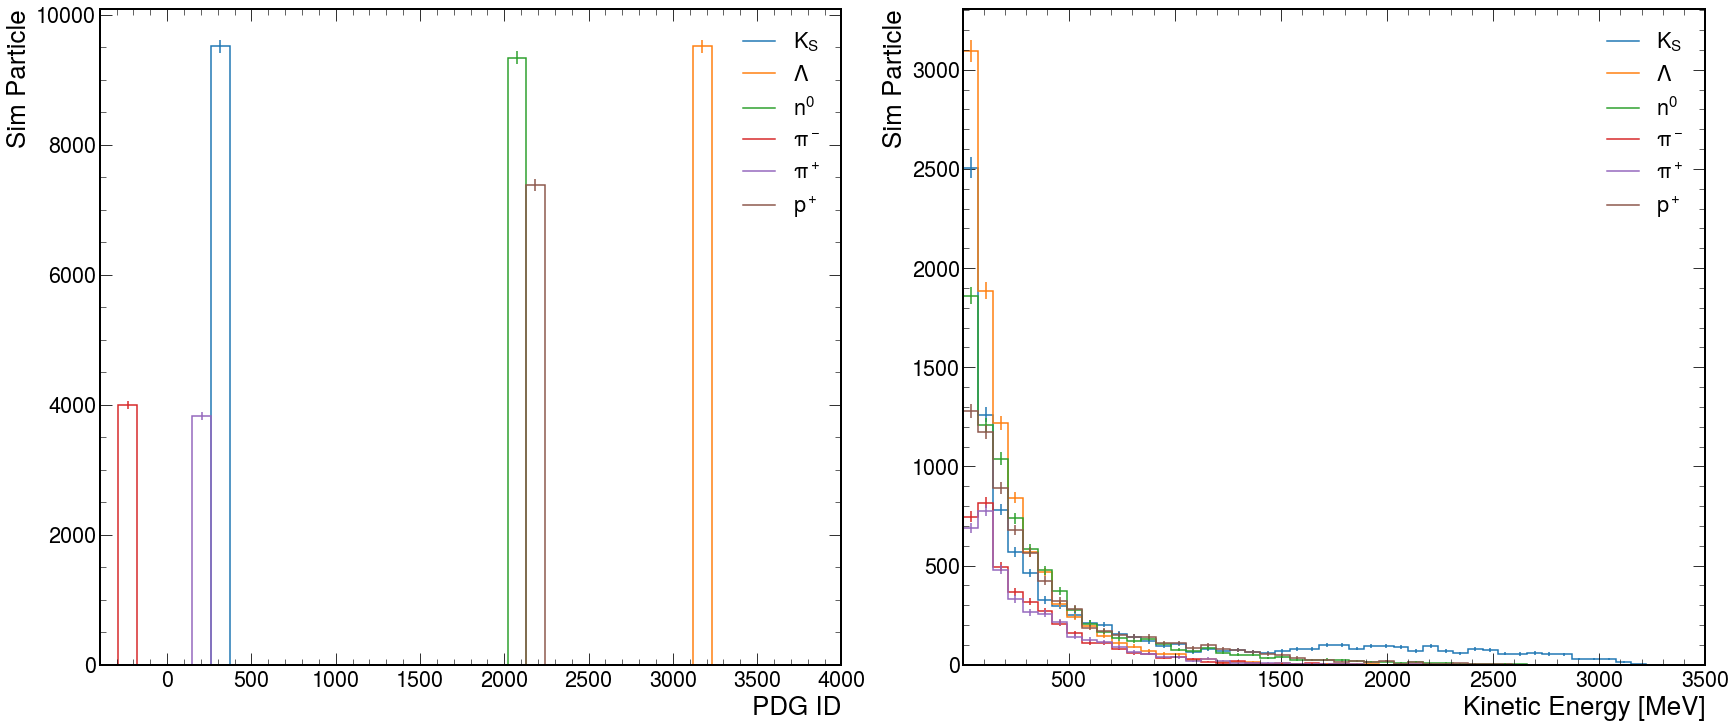

In [12]:
#48 kminus
print(hists["hist_pdgid"])
fig, ax = plt.subplots(1,2, figsize=(24,10), constrained_layout=True)
hist.plot1d(hists["hist_pdgid"],ax=ax[0],clear=False);
leg = ax[0].legend([r'$K_S$', r'$\Lambda$', r'$n^0$', r'$\pi^-$', r'$\pi^+$',r'$p^+$'])

hist.plot1d(hists["hist_ke"],ax=ax[1],clear=False);
leg = ax[1].legend([r'$K_S$', r'$\Lambda$', r'$n^0$', r'$\pi^-$', r'$\pi^+$',r'$p^+$'])